In [1]:
import pandas as pd
import numpy as np
import pycountry
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import ScalarFormatter
from PIL import Image
import os
import seaborn as sns
from matplotlib.patheffects import withStroke
import matplotlib as mpl
from adjustText import adjust_text
import matplotlib.patheffects as pe
from matplotlib.legend_handler import HandlerBase
import matplotlib.image as mpimg



In [21]:
ads_data_aff = pd.read_parquet('all_data_country_clean.parquet')

In [3]:
country_population_resarchers = pd.read_csv('country_population_researchers.csv')
country_population_resarchers['num_researchers'] = country_population_resarchers['Latest_Researchers_per_Million'] * (country_population_resarchers['2023_population'] / 1_000_000)
country_population_resarchers_over_1000 = country_population_resarchers[country_population_resarchers['num_researchers'] > 3000].sort_values(by='num_researchers', ascending=False)
country_population_resarchers_over_1000.shape

(97, 30)

In [4]:
def get_mean_population_per_year(pop_df):
    # Select only year columns (2000–2023)
    year_cols = [str(y) for y in range(2000, 2024)]

    # Melt the wide format into long format
    pop_long = pop_df.melt(
        value_vars=year_cols,
        var_name='year',
        value_name='population'
    )

    # Convert year to integer
    pop_long['year'] = pop_long['year'].astype(int)

    # Group by year and compute mean
    mean_pop_per_year = (
        pop_long.groupby('year')['population']
        .mean()
        .reset_index(name='mean_population')
    )

    return mean_pop_per_year

In [5]:
def get_country_article_stats(
    df,
    country_col='first_author_aff_country_final_valid',
    group_by_year=False,
    group_by_pub=False,
    filter_col=None,
    keyword=None,
    country_stats=None,
    include_eu=True
    ):

    # Manual ISO mapping
    manual_map = {
        "Türkiye": "tr", "Turkey": "tr",
        "Russian Federation": "ru", "Russia": "ru",
        "USA": "us", "United States": "us",
        "UK": "gb", "United Kingdom": "gb",
        "South Korea": "kr", "Korea, Republic of": "kr",
        "North Korea": "kp", "Korea, Democratic People's Republic of": "kp",
        "Iran": "ir", "Iran, Islamic Republic of": "ir",
        "Taiwan": "tw", "Taiwan, Province of China": "tw",
        "European Union": "eu",
    }

    eu_countries = {
        "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Czech Republic",
        "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary",
        "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands",
        "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden"
    }

    def get_country_code(name):
        name = name.strip()
        if name in manual_map:
            return manual_map[name]
        try:
            return pycountry.countries.lookup(name).alpha_2.lower()
        except LookupError:
            return None

    # Filter if needed
    if filter_col and keyword:
        df = df[df[filter_col].str.contains(keyword, case=False, na=False)]

    # Define grouping
    group_keys = [country_col]
    if group_by_year:
        group_keys.append('year')
    if group_by_pub:
        group_keys.append('pub')

    # Group and count
    grouped = df.groupby(group_keys).size().reset_index(name='article_count')
    grouped = grouped.rename(columns={country_col: 'country'})
    grouped['country_code'] = grouped['country'].apply(get_country_code)

    # Merge population stats
    if country_stats is not None:
        stats = country_stats.rename(columns={
            'Country Name': 'country',
            '2023_population': 'population',
            'Latest_Researchers_per_Million': 'researchers_per_million'
        })
        grouped = grouped.merge(stats[['country', 'population', 'researchers_per_million']], on='country', how='left')

        grouped['per_million_people'] = grouped['article_count'] / (grouped['population'] / 1_000_000)
        grouped['num_researchers'] = grouped['researchers_per_million'] * (grouped['population'] / 1_000_000)
        grouped['per_1k_researchers'] = grouped['article_count'] / (grouped['num_researchers'] / 1_000)
    else:
        grouped['per_million_people'] = None
        grouped['per_1k_researchers'] = None

    # --- Add EU manually ---
    if include_eu and country_stats is not None:
        eu_mask = grouped['country'].isin(eu_countries)
        eu_group = grouped[eu_mask]

        group_cols = []
        if group_by_year:
            group_cols.append('year')
        if group_by_pub:
            group_cols.append('pub')

        if not eu_group.empty:
            # Drop rows with missing population or researchers
            valid_eu_group = eu_group.dropna(subset=['population', 'researchers_per_million'])

            if not valid_eu_group.empty:
                if group_cols:
                    # Grouped mode (e.g. per year or per pub)
                    def compute_eu_stats(subgroup):
                        total_articles = subgroup['article_count'].sum()
                        total_population = subgroup['population'].sum()
                        if total_population == 0:
                            return pd.Series({
                                'article_count': total_articles,
                                'per_million_people': None,
                                'per_1k_researchers': None
                            })

                        weighted_rpm = (
                            (subgroup['researchers_per_million'] * subgroup['population']).sum() / total_population
                        )
                        num_researchers = weighted_rpm * (total_population / 1_000_000)

                        return pd.Series({
                            'article_count': total_articles,
                            'per_million_people': total_articles / (total_population / 1_000_000),
                            'per_1k_researchers': total_articles / (num_researchers / 1_000)
                        })

                    eu_summary = valid_eu_group.groupby(group_cols).apply(compute_eu_stats).reset_index()
                else:
                    # Single overall EU row
                    total_articles = valid_eu_group['article_count'].sum()
                    total_population = valid_eu_group['population'].sum()

                    weighted_rpm = (
                        (valid_eu_group['researchers_per_million'] * valid_eu_group['population']).sum() / total_population
                    )
                    num_researchers = weighted_rpm * (total_population / 1_000_000)

                    eu_summary = pd.DataFrame([{
                        'article_count': total_articles,
                        'per_million_people': total_articles / (total_population / 1_000_000),
                        'per_1k_researchers': total_articles / (num_researchers / 1_000)
                    }])

                eu_summary['country'] = 'European Union'
                eu_summary['country_code'] = 'eu'

                # Reorder columns to match grouped
                grouped = pd.concat([grouped, eu_summary], ignore_index=True)



    # Final columns
    cols = ['country', 'country_code', 'article_count', 'per_million_people', 'per_1k_researchers']
    return grouped[cols + [col for col in grouped.columns if col not in cols]]


In [6]:
df_counts =  get_country_article_stats(
    ads_data_aff,
    group_by_year=True,
    group_by_pub =True,
    country_stats=country_population_resarchers,
    include_eu=True
)

df_counts

C:\Users\adbva\AppData\Local\Temp\ipykernel_31168\1400521257.py:112: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eu_summary = valid_eu_group.groupby(group_cols).apply(compute_eu_stats).reset_index()


,country,country_code,article_count,per_million_people,per_1k_researchers,year,pub,population,researchers_per_million,num_researchers
0,Afghanistan,af,1.0,0.024123,NaN,2021,Heliyon,41454761.0,NaN,NaN
1,Afghanistan,af,1.0,0.024123,NaN,2021,Remote Sensing Applications: Society and Envir...,41454761.0,NaN,NaN
2,Afghanistan,af,1.0,0.024123,NaN,2022,Stochastic Environmental Research and Risk Ass...,41454761.0,NaN,NaN
3,Afghanistan,af,1.0,0.024123,NaN,2024,Acta Geophysica,41454761.0,NaN,NaN
4,Afghanistan,af,1.0,0.024123,NaN,2024,Discover Geoscience,41454761.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
137714,European Union,eu,8.0,0.035335,0.008727,2025,npj Computational Mathematics,NaN,NaN,NaN
137715,European Union,eu,1.0,0.094534,0.025380,2025,npj Ocean Sustainability,NaN,NaN,NaN
137716,European Union,eu,2.0,0.033902,0.016240,2025,npj Quantum Information,NaN,NaN,NaN
137717,European Union,eu,1.0,0.012008,0.002537,2025,npj Scientific of Learning,NaN,NaN,NaN


In [7]:
def plot_country_bar_chart_with_flags(
    data,
    value_col='article_count',
    top_n=30,
    title=None,
    xlabel=None,
    filename=None,
    flag_dir='flags',
    figsize=(12, 9),
    zoom=0.3,
    use_log=False
    ):
    
    # --- Prep ---
    plot_data = data.copy().sort_values(by=value_col, ascending=False).head(top_n)
    countries = plot_data['country'].tolist()
    values = plot_data[value_col].tolist()
    rounded_values = [int(round(v)) if pd.notnull(v) else None for v in values]

    # Default labels
    if not title:
        title = f"Top {top_n} Countries by {value_col.replace('_', ' ').title()}"
    if not xlabel:
        xlabel = f"Publications {value_col.replace('_', ' ').title()}"
    if not filename:
        filename = f"figures/top_countries_by_{value_col}.png"

    # --- Plot ---
    plt.style.use("default")
    fig, ax = plt.subplots(figsize=figsize)

    # Full empty bars
    ax.barh(
        countries,
        [max(values)] * len(countries),
        edgecolor='#bbb',
        facecolor='none',
        linewidth=1,
        alpha=0.5,
    )

    # Filled bars
    bars = ax.barh(
        countries,
        values,
        color=['#614051'] * len(countries)
    )

    # X scale
    if use_log:
        ax.set_xscale('log')
        formatter = ScalarFormatter(useMathText=False)
        formatter.set_scientific(False)
        formatter.set_useOffset(False)
        ax.xaxis.set_major_formatter(formatter)
        ax.set_xlim(left=max(1, min(values)) * 0.8, right=max(values) * 1.3)
    else:
        ax.set_xlim(left=0, right=max(values) * 1.05)

    # Labels & grid
    fig.text(-0.03, 0.91, title, ha='left', fontsize=13, weight='bold')
    fig.text(0.9, 0.915, "Data Source: SAO/NASA Astrophysics Data System (ADS)", 
         ha='right', fontsize=9, color='gray')
    
    ax.set_xlabel(xlabel, fontsize=14, weight='bold')
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_ylim(-0.5, len(countries) - 0.5)

    # Add flags & country names
    for i, row in plot_data.iterrows():
        idx = plot_data.index.get_loc(i)
        y_axes = (len(countries) - idx - 0.5) / len(countries)

        # Country name
        ax.text(-0.05, y_axes, row['country'], transform=ax.transAxes,
                va='center', ha='right', fontsize=12, color='black')

        # Flag
        code = row.get('country_code')
        if code:
            flag_path = os.path.join(flag_dir, f"{code}.png")
            if os.path.exists(flag_path):
                img = OffsetImage(Image.open(flag_path).convert("RGBA"), zoom=zoom)
                ab = AnnotationBbox(
                    img, (0.03, y_axes), xycoords='axes fraction',
                    boxcoords="offset points", frameon=False, pad=0,
                    xybox=(-25, 0), box_alignment=(1, 0.5)
                )
                ax.add_artist(ab)

    # Value labels on bars
    for bar, val in zip(bars, rounded_values):
        if val is not None:
            ax.text(val * 0.8 if not use_log else val * 0.81,
                    bar.get_y() + bar.get_height() / 2,
                    f"{val:,}", va='center', ha='left', fontsize=7,
                    color='white' if not use_log else 'white', weight='bold')

    # Rank labels
    if use_log:
        right_pos = 10 ** (np.log10(max(values)) + 0.095)
    else:
        right_pos = max(values) * 1.04

    for i, bar in enumerate(bars):
        ax.text(right_pos, bar.get_y() + bar.get_height() / 2,
                f"#{i+1}", va='center', ha='right', fontsize=10, color='gray')

    ax.invert_yaxis()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close()


### For all journals

In [8]:
# Get the precomputed stats
df_stats = get_country_article_stats(
    ads_data_aff,
    group_by_year=False,
    country_stats=country_population_resarchers_over_1000,
    include_eu=True
)

# Plot raw counts
plot_country_bar_chart_with_flags(df_stats, xlabel = 'Number of Publications', title = 'Top Countries by Number of Publications (2000-2025)', filename = "figures/top_countries.png", value_col='article_count', use_log=True)

# Plot normalized by population
plot_country_bar_chart_with_flags(df_stats, xlabel = 'Number of Publications', title = 'Top Publishing Countries per 1M People (2000-2025)', filename = "figures/top_countries_per_million.png", value_col='per_million_people')

# Plot normalized by researchers
plot_country_bar_chart_with_flags(df_stats, xlabel = 'Number of Publications', title = 'Top Publishing Countries per 1K Researcher (2000-2025)', filename = "figures/top_countries_per_researcher.png",  value_col='per_1k_researchers')


### For Q1 journals

In [9]:
ads_data_aff_q1 = ads_data_aff[ads_data_aff['sjr_quartile'] == 'Q1']


# Get the precomputed stats
df_stats_q1 = get_country_article_stats(
    ads_data_aff_q1,
    group_by_year=False,
    country_stats=country_population_resarchers_over_1000,
    include_eu=True
)

# Plot raw counts
plot_country_bar_chart_with_flags(df_stats_q1, xlabel = 'Number of Publications', title = 'Top Countries by Number of Publications (SJR Q1 journals) (2000-2025)', filename = "figures/top_countries_q1.png", value_col='article_count', use_log=True)

# Plot normalized by population
plot_country_bar_chart_with_flags(df_stats_q1, xlabel = 'Number of Publications', title = 'Top Publishing Countries per 1M People (SJR Q1 journals) (2000-2025)', filename = "figures/top_countries_per_million_q1.png", value_col='per_million_people')

# Plot normalized by researchers
plot_country_bar_chart_with_flags(df_stats_q1, xlabel = 'Number of Publications', title = 'Top Publishing Countries per 1K Researcher (SJR Q1 journals) (2000-2025)', filename = "figures/top_countries_per_researcher_q1.png",  value_col='per_1k_researchers')


## Publications per year

In [10]:
def plot_top_countries_over_time(
    df,
    top_n=10,
    value_col='article_count',
    year_col='year',
    country_col='country',
    title='Top Countries by Number of Publications',
    figsize=(11, 7),
    color_palette='colorblind',
    filename = None,
    ):

    flag_colors = {
    "China": "#de2910",           # Red
    "United States": "#5864A9",   # Navy Blue
    "European Union": "#003399",  # EU blue
    "Germany": "#000000",         # Black (top stripe)
    "United Kingdom": "#012169",  # Deep blue
    "India": "#ff9933",           # Saffron (top stripe)
    "France": "#0055a4",          # Blue stripe
    "Russia": "#0033a0",          # Blue stripe
    "Japan": "#bc002d",           # Red circle
    "South Korea": "#003478",     # Blue
    "Italy": "#008c45",           # Green stripe
    # ...add more as needed
    }

    def get_flag_image(code, folder="flags", zoom=0.08):
        path = os.path.join(folder, f"{code}.png")
        if os.path.exists(path):
            img = Image.open(path).convert("RGBA")
            return OffsetImage(img, zoom=zoom)
        return None

    manual_map = {
        "USA": "us", "United States": "us",
        "UK": "gb", "United Kingdom": "gb",
        "South Korea": "kr", "Korea, Republic of": "kr",
        "Iran": "ir", "Iran, Islamic Republic of": "ir",
        "Taiwan": "tw", "Taiwan, Province of China": "tw",
        "European Union": "eu",  # manually added if needed
        # ... add any special cases
    }

    def get_country_code(name):
        name = name.strip()
        if name in manual_map:
            return manual_map[name]
        try:
            return pycountry.countries.lookup(name).alpha_2.lower()
        except LookupError:
            return None

    mean_pop_df = get_mean_population_per_year(country_population_resarchers)

    # Top countries
    top_countries = (
        df.groupby(country_col)[value_col]
        .sum()
        .sort_values(ascending=False)
        .head(top_n)
        .index.tolist()
    )

    # Pivot data
    subset = df[df[country_col].isin(top_countries)]
    pivot_df = subset.pivot(index=year_col, columns=country_col, values=value_col).fillna(0)
    pivot_df = pivot_df[top_countries]

    # Theme setup
    # Reset to defaults
    mpl.rcParams.update(mpl.rcParamsDefault)
    sns.set_theme(style='whitegrid')
    #mpl.rcParams['axes.facecolor'] = '#e3f2fd'
    #mpl.rcParams['axes.edgecolor'] = '#cccccc'
    #mpl.rcParams['grid.color'] = '#dddddd'
    #mpl.rcParams['font.family'] = 'DejaVu Sans

    #colors = sns.color_palette(color_palette, n_colors=top_n)
    colors = [flag_colors[country] for country in pivot_df.columns]


    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    #fig.patch.set_facecolor('#f0f8ff')  # Optional

    mean_line, = ax.plot(
    mean_pop_df['year'],
    mean_pop_df['mean_population'] / 50000,
    linestyle='--',
    linewidth=2,
    color='black',
    marker='o',
    markersize=4,
    label='World Mean Population / 50K'  # <- add label here
    )

    mean_line, = ax.plot(
    mean_pop_df['year'],
    mean_pop_df['mean_population'] / 50000,
    linestyle='--',
    linewidth=2,
    color='black',
    marker='o',
    markersize=4,
    label='World Mean Population / 50K'  # <- add label here
    )

    for i, country in enumerate(pivot_df.columns):
        ax.plot(
            pivot_df.index,
            pivot_df[country],
            label=None,
            marker='o',
            linewidth=2.2,
            markersize=6,
            color=colors[i],
            path_effects=[
                pe.withStroke(linewidth=3.5, foreground='white')  # white outline
            ]
        )

    # Annotate mean population
    #ax.annotate("Wolrd Mean Population",
    #            xy=(mean_pop_df['year'].max()-10, mean_pop_df['mean_population'].iloc[-1] / 50000),
    #            xytext=(-50, 1),
    #            textcoords='offset points',
    #            fontsize=10,
    #            color='black',
    #            rotation = 3,
    #            #arrowprops=dict(arrowstyle='->', color='black')
    #            )
    
    # Annotate each country at the final point
    texts = []
    for i, country in enumerate(pivot_df.columns):
        last_year = pivot_df.index.max()-1
        last_value = pivot_df.loc[last_year, country]
        
        text = ax.text(
            last_year,
            last_value,
            country,
            fontsize=11,
            color=colors[i],
            ha='left',
            va='center',
            weight='bold',
            path_effects=[withStroke(linewidth=3, foreground='white')]
        )
        texts.append(text)

    adjust_text(texts, ax=ax, only_move={'text': 'y'}, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    """
    for i, country in enumerate(pivot_df.columns):
        y_vals = pivot_df[country]
        color = colors[i]
        code = get_country_code(country)

        # Plot the line without markers
        ax.plot(pivot_df.index, y_vals, linewidth=2, color=color)

        if code:
            img = get_flag_image(code, zoom=0.15)

            if img:
                for year, value in y_vals.items():
                    ab = AnnotationBbox(
                        img,
                        (year, value),
                        frameon=False,
                        box_alignment=(0.5, 0.5),
                        pad=0,
                        alpha = 0.01,
                    )
                    ax.add_artist(ab)
    """




    ax.annotate(
    "Data drop\n(incomplete year)",
    xy=(2025, 0.83),  # x in data coords, y in axes fraction
    xycoords=('data', 'axes fraction'),
    xytext=(20, 0),
    textcoords="offset points",
    fontsize=10,
    color='gray',
    rotation=-90,
    ha='center',
    va='center'
    )



    # Labels & grid
    fig.text(0.01, 1.01, title, ha='left', fontsize=15, weight='bold')
    fig.text(0.99, 1.015, "Data Source: SAO/NASA Astrophysics Data System (ADS)", 
         ha='right', fontsize=9, color='gray')
    
    #ax.grid(axis='x', visible=False)
    ax.set_xlabel("Year", fontsize=14, weight='bold')
    ax.set_ylabel("Number of Publications", fontsize=14, weight='bold')
    ax.tick_params(axis='both', labelsize=11, length=5)
    ax.grid(True, linestyle='--', axis='y', alpha=0.3)
    ax.set_axisbelow(True)
    ax.set_ylim(0, pivot_df.max().max() * 1.05)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))

    # Remove top/right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Legend inside upper left or outside
    ax.legend(
        title=None,
        fontsize=10,
        loc='upper left',
        frameon=True,
        framealpha=0.92,
        facecolor='white',
        edgecolor='gray'
    )
    ax.legend_.remove()
    ax.legend(["World Mean Population / 50K"], loc="upper left")

     # Customize spines (frame)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_color('black')

    # Hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


C:\Users\adbva\AppData\Local\Temp\ipykernel_31168\1400521257.py:112: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eu_summary = valid_eu_group.groupby(group_cols).apply(compute_eu_stats).reset_index()


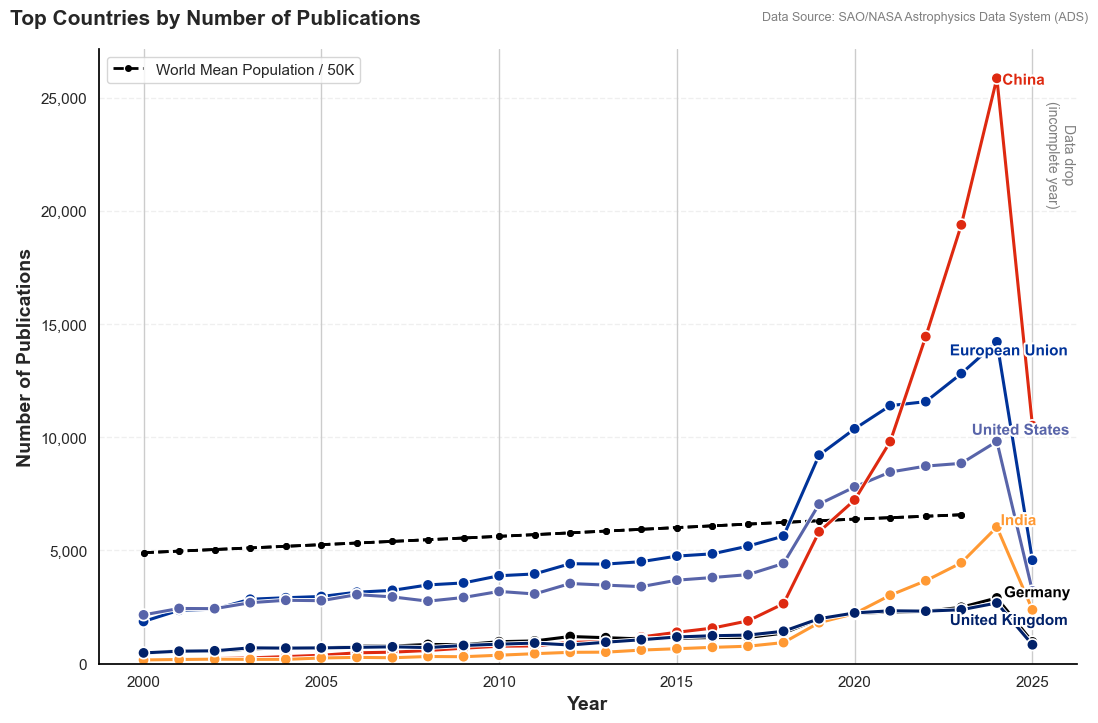

In [11]:
# Get the precomputed stats
df_yearly = get_country_article_stats(
    ads_data_aff,
    group_by_year=True,
    country_stats=country_population_resarchers_over_1000,
    include_eu=True,
)

plot_top_countries_over_time(
    df_yearly,
    top_n=6,
    value_col='article_count',
    color_palette='Set2',
    filename = 'figures/top_countries_30_per_year_with_population.png'
)


C:\Users\adbva\AppData\Local\Temp\ipykernel_31168\1400521257.py:112: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eu_summary = valid_eu_group.groupby(group_cols).apply(compute_eu_stats).reset_index()


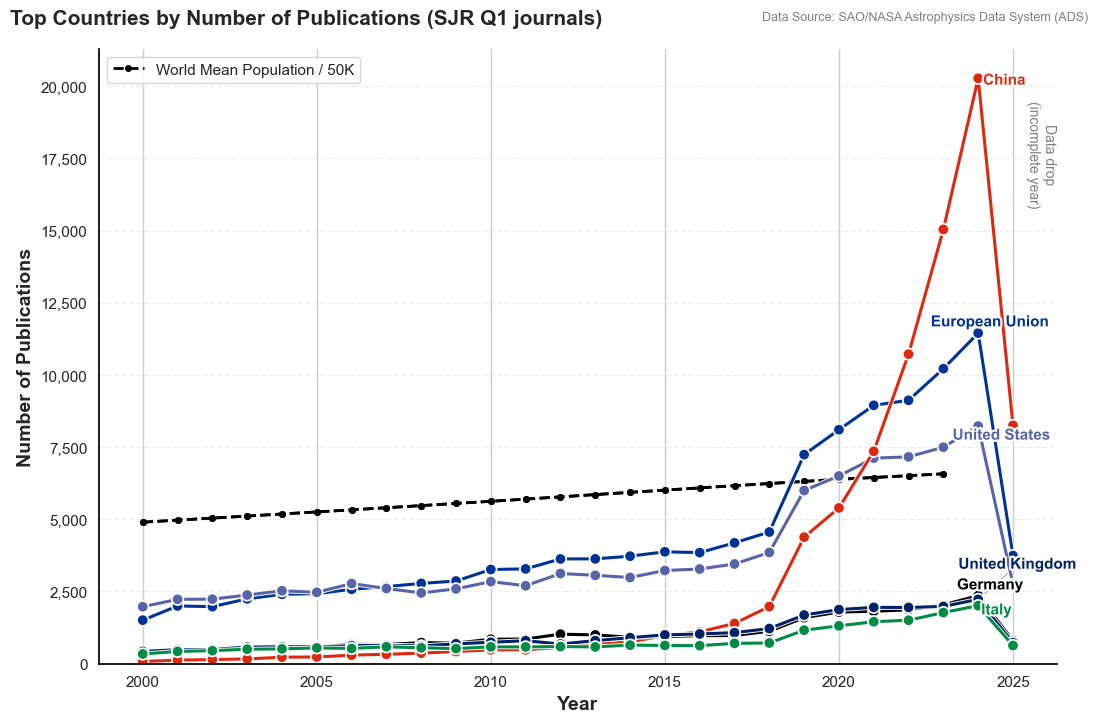

In [12]:
ads_data_aff_q1 = ads_data_aff[ads_data_aff['sjr_quartile'] == 'Q1']

df_yearly = get_country_article_stats(
    ads_data_aff_q1,
    group_by_year=True,
    country_stats=country_population_resarchers_over_1000,
    include_eu=True,
)

plot_top_countries_over_time(
    df_yearly,
    top_n=6,
    value_col='article_count',
    color_palette='Set2',
    title='Top Countries by Number of Publications (SJR Q1 journals)',
    filename = 'figures/top_countries_30_per_year_with_population_Q1.png'
)

In [13]:
selected_countries = ['European Union', 'United States', 'China']
china_usa_eu = ads_data_aff[ads_data_aff['country_grouped'].isin(selected_countries)]
china_usa_eu.shape

(367702, 11)

In [14]:
ads_data_aff_Cosmology = ads_data_aff[ads_data_aff.my_keyword.str.contains('Cosmology')]
print (len(ads_data_aff_Cosmology))



keywords = (
    ads_data_aff["grouped_keywords"]
    .value_counts(dropna=True)
    .reset_index()
)

keywords.head(40)

136007


,grouped_keywords,count
0,Astronomy,180557
1,AI,170516
2,Cosmology,135967
3,Astrobiology,120592


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl

def plot_keyword_comparison_grouped(
    df, countries, keywords, years,
    title="Grouped by Country and Year per Keyword",
    filename=None
):
    df = df.dropna(subset=['grouped_keywords']).copy()
    df['grouped_keywords'] = df['grouped_keywords'].str.lower()
    df = df.assign(keyword_list=df['grouped_keywords'].str.split(','))
    df = df.explode('keyword_list')
    df['keyword_list'] = df['keyword_list'].str.strip()

    # Preserve original casing for xtick labels
    keywords_lower = [kw.lower() for kw in keywords]
    keyword_label_map = {kw.lower(): kw for kw in keywords}  # e.g. "ai" -> "AI"
    years = sorted(years)

    df = df[df['keyword_list'].isin(keywords_lower)]
    df = df[df['country_grouped'].isin(countries)]
    df = df[df['year'].isin(years)]

    # Count publications
    grouped = df.groupby(['keyword_list', 'country_grouped', 'year']).size().reset_index(name='count')
    pivot = grouped.pivot_table(index=['keyword_list', 'country_grouped', 'year'], values='count', fill_value=0)

    # Reset to defaults
    mpl.rcParams.update(mpl.rcParamsDefault)
    sns.set_theme(style='whitegrid')
    #mpl.rcParams['axes.facecolor'] = '#e3f2fd'
    #mpl.rcParams['axes.edgecolor'] = '#cccccc'
    #mpl.rcParams['grid.color'] = '#dddddd'
    #mpl.rcParams['font.family'] = 'DejaVu Sans'

    # Setup
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.08
    spacing_between_years = 0.00
    spacing_between_countries = 0.03
    spacing_between_keywords = 0.12
    colors = {
        "China": "#de2910",
        "United States": "#5864A9",
        "European Union": "#003399"
    }

    x = 0
    xtick_positions = []
    xtick_labels = []
    legend_handles = {}

    for keyword in keywords_lower:
        for country in countries:
            for i, year in enumerate(years):
                value = pivot.loc[(keyword, country, year)] if (keyword, country, year) in pivot.index else 0
                xpos = x
                bar = ax.bar(xpos, value, width=bar_width, color=colors[country])
                if country not in legend_handles:
                    legend_handles[country] = bar[0]
                # Add year label above bar
                ax.text(xpos, value + 100, str(year), ha='center', va='bottom', fontsize=8, rotation=90)
                x += bar_width + spacing_between_years
            x += spacing_between_countries
        xtick_positions.append(x - (len(years) * (bar_width + spacing_between_years) + spacing_between_countries * len(countries) + 0.5) / 2)
        xtick_labels.append(keyword_label_map.get(keyword, keyword))  # Use original casing
        x += spacing_between_keywords




    # Labels & grid
    fig.text(0.01, 1.01, title, ha='left', fontsize=15, weight='bold')
    fig.text(0.99, 1.015, "Data Source: SAO/NASA Astrophysics Data System (ADS)", 
             ha='right', fontsize=9, color='gray')

    ax.grid(axis='x', visible=False)
    #ax.set_xticks(xtick_positions)
    #ax.set_xticklabels(xtick_labels, fontsize=11, weight='bold')



    ax.set_ylabel("Number of Publications", fontsize=14, weight='bold')
    ax.legend(legend_handles.values(), legend_handles.keys(), loc='upper left')

    # Automatically increase y-axis to give space for labels
    ymax = ax.get_ylim()[1]
    ax.set_ylim(top=ymax * 1.02)  # or 1.15 for more padding


    # Customize spines (frame)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_color('black')

    # Hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)




    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    import matplotlib.image as mpimg

    flag_dir = "flags"
    flag_map = {
        "China": "cn.png",
        "United States": "us.png",
        "European Union": "eu.png"
    }



    # Reconstruct x-positions of country centers for each keyword
    flag_y = -0.01  # y-position in axes fraction
    x = 0

    for keyword in keywords_lower:
        for country in countries:
            # Calculate the center x-position of this country's group of bars
            bar_offsets = [x + i * bar_width for i in range(len(years))]
            center_x = sum(bar_offsets) / len(bar_offsets)

            # Load flag image
            iso_file = flag_map.get(country)
            flag_path = os.path.join(flag_dir, iso_file)
            if os.path.exists(flag_path):
                img = mpimg.imread(flag_path)
                imagebox = OffsetImage(img, zoom=0.3)

                # Place the flag using x in data coords, y in axes fraction
                ab = AnnotationBbox(
                    imagebox,
                    (center_x, flag_y),  # center_x in data units, flag_y in axes fraction
                    xycoords=('data', 'axes fraction'),
                    frameon=False,
                    box_alignment=(0.5, 1)
                )
                ax.add_artist(ab)

            x += bar_width * len(years) + spacing_between_countries
        x += spacing_between_keywords

    # Move keyword labels lower
    for xpos, label in zip(xtick_positions, xtick_labels):
        ax.text(
            xpos, -0.06,  # y in axes coords, below frame
            label,
            ha='center', va='top',
            fontsize=13, weight='bold',
            transform=ax.get_xaxis_transform()
        )

    ax.set_xticks([])  # remove tick markers

    plt.tight_layout()

    # Save if filename provided
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

    #plt.show()
    plt.close()


In [16]:
plot_keyword_comparison_grouped(
    df=china_usa_eu,
    countries=["China", "United States", "European Union"],
    keywords=["Cosmology", "Astronomy", "Astrobiology", "AI"],
    years=[2020, 2022, 2024],
    title="AI and Astro-Keywords Publications",
    filename="figures/ai_astropub_keywords_trend.png"
)

china_usa_eu_q1 =china_usa_eu[china_usa_eu.sjr_quartile == 'Q1']
plot_keyword_comparison_grouped(
    df=china_usa_eu_q1,
    countries=["China", "United States", "European Union"],
    keywords=["Cosmology", "Astronomy", "Astrobiology", "AI"],
    years=[2020, 2022, 2024],
    title="AI and Astro-Keywords Publications (SJR Q1 journals)",
    filename="figures/ai_astropub_keywords_trend_q1.png"
)

C:\Users\adbva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
C:\Users\adbva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
C:\Users\adbva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) ins

In [20]:
ads_data_aff

,bibcode,my_keyword,grouped_keywords,pub,year,citation_count,first_author_aff_country_final_valid,journal,country_grouped,country_code,sjr_quartile
0,1977ElL....13..717B,Astrobiology,Astrobiology,American Institute of Physics Conference Series,2024,0,Denmark,ElL,European Union,dk,None
1,2000A&A...353....1R,Cosmology,Cosmology,Astronomy and Astrophysics,2000,12,Germany,A&A,European Union,de,Q1
2,2000A&A...353...25M,"AGN, Cosmology, Galaxy",Cosmology,Astronomy and Astrophysics,2000,262,Germany,A&A,European Union,de,Q1
3,2000A&A...353...41S,"Cosmology, Galaxy",Cosmology,Astronomy and Astrophysics,2000,88,Germany,A&A,European Union,de,Q1
4,2000A&A...353...57G,"Cosmology, Galaxy",Cosmology,Astronomy and Astrophysics,2000,20,Italy,A&A,European Union,it,Q1
...,...,...,...,...,...,...,...,...,...,...,...
607627,2025npjSA...3....2L,Astrobiology,Astrobiology,npj Sustainable Agriculture,2025,0,Belgium,npjSA,European Union,be,None
607628,2025npjSA...3...10H,Astrobiology,Astrobiology,npj Sustainable Agriculture,2025,0,United States,npjSA,United States,us,None
607629,2025npjSA...3...12T,AI,AI,npj Sustainable Agriculture,2025,0,Canada,npjSA,Canada,ca,None
607630,2025npjSL..10....1A,AI,AI,npj Scientific of Learning,2025,0,Germany,npjSL,European Union,de,None


In [71]:
import pandas as pd
from scipy.stats import kendalltau
from numpy import trapz

def compute_growth_metrics(data, year_col='year', country_col='first_author_aff_country_final_valid', 
                           start_year=None, end_year=None):
    """
    Compute TSI (Trend Strength Index) and AUC (Area Under Curve) for publication growth per country.

    Parameters:
    - data: DataFrame with columns including year, country, and one row per publication
    - year_col: name of the column containing publication year
    - country_col: name of the column with cleaned country names
    - start_year: int or None, the first year to include (inclusive)
    - end_year: int or None, the last year to include (inclusive)

    Returns:
    - summary_df: DataFrame with columns [Country, TSI, AUC], sorted by TSI descending
    """
    
    # Count publications per country and year
    pub_counts = (
        data
        .groupby([country_col, year_col])
        .size()
        .reset_index(name='count')
        .rename(columns={country_col: 'country', year_col: 'year'})
    )

    # Filter by year range if provided
    if start_year is not None:
        pub_counts = pub_counts[pub_counts['year'] >= start_year]
    if end_year is not None:
        pub_counts = pub_counts[pub_counts['year'] <= end_year]

    # Calculate TSI
    def compute_tsi(sub_df):
        sub_df = sub_df.sort_values('year')
        if len(sub_df) < 2 or sub_df['count'].iloc[0] == 0:
            return 0  # avoid division by zero or invalid trends
        tau, _ = kendalltau(sub_df['year'], sub_df['count'])
        growth = (sub_df['count'].iloc[-1] - sub_df['count'].iloc[0]) / sub_df['count'].iloc[0]
        return tau * growth

    tsi_scores = {
        country: compute_tsi(sub_df)
        for country, sub_df in pub_counts.groupby('country')
    }

    # Calculate AUC
    auc_scores = {
        country: trapz(sub_df.sort_values('year')['count'], sub_df['year'])
        for country, sub_df in pub_counts.groupby('country')
    }

    # Total number of articles per country (summing yearly counts)
    total_articles = pub_counts.groupby('country')['count'].sum().to_dict()


    # Combine and return
    summary_df = pd.DataFrame({
    "Country": list(tsi_scores.keys()),
    "TSI": list(tsi_scores.values()),
    "AUC": [auc_scores[c] for c in tsi_scores.keys()],
    "Total_Articles": [total_articles[c] for c in tsi_scores.keys()]
    })
    return summary_df.sort_values("TSI", ascending=False)

summary_df = compute_growth_metrics(
    ads_data_aff,
    start_year=2000,
    end_year=2024
)

summary_df.head(5)


,Country,TSI,AUC,Total_Articles
140,Pakistan,748.997732,3207.5,3598
158,Saudi Arabia,533.623881,2034.5,2351
183,Thailand,304.576792,1189.0,1356
125,Morocco,285.066443,922.5,1084
15,Bangladesh,268.641700,812.5,979


114


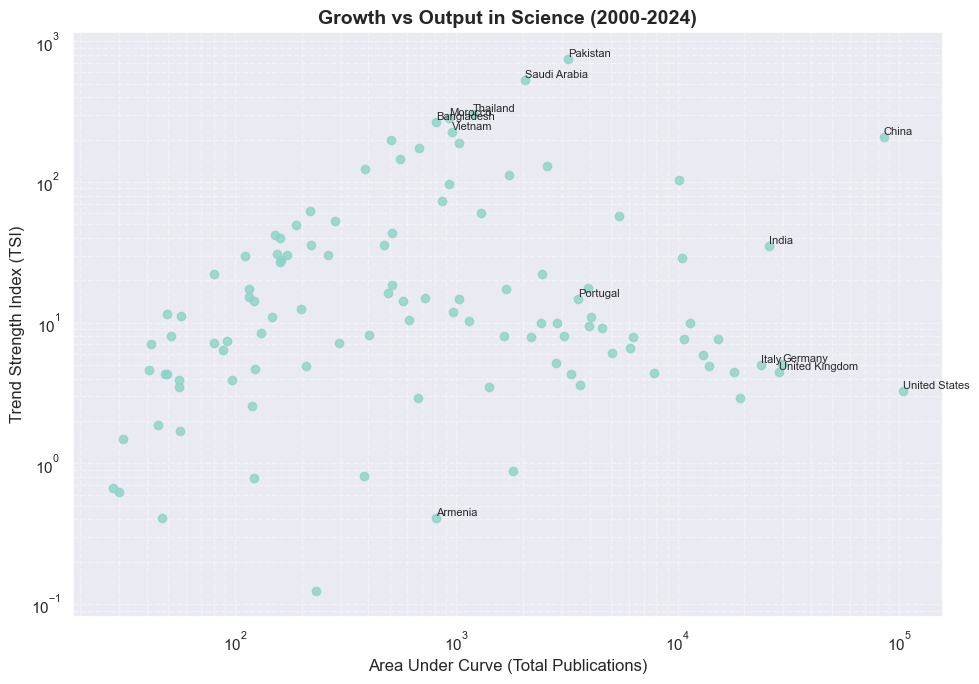

In [131]:
import matplotlib.pyplot as plt
import numpy as np

def plot_growth_vs_output(
    summary_df,
    label_quantile=0.97,
    figsize=(10, 7),
    title="Growth vs Total Output of Publications (log-log scale)",
    filename=None,
    annotate_countries=None  # ✅ new argument
):
    """
    Plots a log-log scatter of TSI vs AUC for countries.

    Parameters:
    - summary_df: DataFrame with columns ["Country", "TSI", "AUC"]
    - label_quantile: float, quantile threshold for labeling standout countries
    - figsize: tuple, size of the figure
    - title: str, title of the plot
    - filename: str or None, if provided the figure will be saved to this path
    - annotate_countries: list of country names to force annotation
    """

    # Filter out non-positive values (log scale requirement)
    plot_df = summary_df.copy()
    plot_df = plot_df[(plot_df["AUC"] > 0) & (plot_df["TSI"] > 0)]

    # Normalize country name list if provided
    annotate_countries = set(annotate_countries or [])

    # Start plot
    plt.figure(figsize=figsize)
    plt.scatter(plot_df["AUC"], plot_df["TSI"], alpha=0.8)

    # Add country labels for outliers or manually specified ones
    for _, row in plot_df.iterrows():
        if (
            row["Country"] in annotate_countries or
            row["TSI"] > plot_df["TSI"].quantile(label_quantile) or
            row["AUC"] > plot_df["AUC"].quantile(label_quantile)
        ):
            plt.text(row["AUC"], row["TSI"], row["Country"], fontsize=8, ha='left', va='bottom')

    # Log-log scale
    plt.xscale("log")
    plt.yscale("log")

    # Labels and styling
    plt.xlabel("Area Under Curve (Total Publications)", fontsize=12)
    plt.ylabel("Trend Strength Index (TSI)", fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.grid(True, which="both", linestyle='--', alpha=0.4)
    plt.tight_layout()

    # Save if filename provided
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()


summary_df = compute_growth_metrics(ads_data_aff, start_year=2000, end_year=2024)


summary_df_gt100_articles = summary_df[summary_df.Total_Articles > 24]
print (len(summary_df_gt100_articles))

highlight = ["Armenia", "Portugal"]

plot_growth_vs_output(
    summary_df_gt100_articles,
    label_quantile=0.95,
    annotate_countries=highlight,
    title="Growth vs Output in Science (2000-2024)",
    filename="figures/tsi_vs_auc_manual_labels.png"
)
